In [12]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import ouparams.ouparams as ou
from scipy import stats,signal


class Pt_Preparation:
    
    def __init__(self,ticker,s_date,e_date):
        self.ticker=ticker #ticker is list of stock ticker
        self.s_date=s_date #data yg digunakan, start date,obj dt.datetime(YYYY,M,D)
        self.e_date=e_date #data yg digunakan, end date, obj dt.datetime(YYYY,M,D)
        self.df=self.df_data
        self.fs=25    #frekuensi rate untuk FFT (Fast Fourier Transform) : parameter fft dapat dirubah-rubah
        self.bar_width=0.00009 #for bar width of plot histogram from FFT result : parameter fft dapat dirubah-rubah
        
    @property
    def df_data(self):
        
        df=pd.DataFrame()
        
        for i in self.ticker:
            ticker=yf.Ticker(i)
            df[i]=ticker.history(start=self.s_date, end=self.e_date, interval="1d")['Close']

        df.dropna(inplace=True)
        return df
    
    
    def coint_coef(self):
        
        df_log=np.log(self.df)
        
        tickers=self.ticker
        
        df_coint=pd.DataFrame()
        for i in tickers:
            for j in tickers:
                if i==j:
                    df_coint.loc[i,j]=0
                else:
                    p_cointegration=coint(df_log[i],df_log[j])
                    df_coint.loc[i,j]=p_cointegration[1]
        
        return sns.heatmap(df_coint)
    
class Pairtrading(Pt_Preparation):
    
    def __init__(self,ticker,s_date,e_date,stock_A,stock_B): 
        super().__init__(ticker,s_date,e_date)
        self.stock_A=stock_A #format string, harga lebih tinggi dibanding harga B
        self.stock_B=stock_B #fromat string, harga lebih rendah dibanding harga A
        self.X_ou=self.X_ou_met
        
        
    @property
    def u(self):
        return np.log(self.df.loc[:,self.stock_A]) #data price stock A dalam skala logaritmic
    
    @property
    def v(self):
        return np.log(self.df.loc[:,self.stock_B]) #data price stock B dalam skala logaritmic
        
    def plot_coint(self):
        
        sns.set_theme()
        
        plt.figure(figsize=(20,5))
        plt.plot(self.u,label=self.u.name,color='green')
        plt.plot(self.v,label=self.v.name,color='red')
        plt.legend()
        plt.title('COINTEGRATION SAHAM '+ self.u.name+' and '+self.v.name,fontsize=20)
        
   
    @property
    def alpha_beta(self):
         # A,B adalah jumlah aset dalam rupiah, alpha dan beta jumlah lembar aset, A=1
    
        BperA=np.linspace(0.001,1,100)
        
        u=self.u
        v=self.v
        
        # Fungsi likelihood normal distribution dengan parameter mu dan sigma dari OU Process

        def likelihood_ou(x,mu,sigma):
    
            likelihood=1
    
            for i in x:
                prob_x=stats.norm.pdf(i,loc=mu, scale=sigma)
                likelihood=likelihood*prob_x
            
            return np.log(likelihood)
        
        df_ou=pd.DataFrame()
        
        for value in BperA:
            alpha=1/u[0]       #tiap Rp 1,- yang kita investasikan
            beta=value/v[0]    
            
            X_ou=abs(alpha*u-beta*v)
            
            mu, sigma, theta= ou.find(X_ou)
            
            mu_ou=mu
            sigma_ou=sigma/np.sqrt(2*theta)
            
            df_ou.loc[value,'Likelihood']=likelihood_ou(X_ou,mu_ou,sigma_ou)
            
        value_max=df_ou.where(df_ou==df_ou.max()).dropna().index.values
            
        alpha=1/u[0]
        beta=value_max[0]/v[0]
           
        return alpha,beta
    
    @property
    def X_ou_met(self):
        
        u=self.u
        v=self.v
        
        a=self.alpha_beta[0]
        b=self.alpha_beta[1]
        
        return abs(a*u-b*v)
    
    @property
    def param_ou(self):
        
        X_ou=self.X_ou #X_ou optimal
        
        return ou.find(X_ou) #parameter mu,sigma,theta dengan X_ou optimal
    
    @property
    def sg_smoothing(self, window_length=25, poly_order=3):
        
        X_ou=self.X_ou
        
        X_sm=signal.savgol_filter(X_ou,window_length=window_length,polyorder=poly_order)
        
        return pd.Series(data=X_sm,index=X_ou.index)
    
    def plot_pt(self):
        
        sns.set_theme()
        
        X=self.X_ou
        X_smooth=self.sg_smoothing
        mu=self.param_ou[0]
        
        sns.set_theme()
        plt.figure(figsize=(20,5))
        plt.plot(X,color='r',label="Original")
        plt.plot(X_smooth,color='black',linewidth=1,label="Smoothing")
        plt.axhline(mu,linestyle='--',linewidth=0.8,color='y',label="Average")
        plt.legend()
    
    
    @property
    def transform (self):
        
        x=self.sg_smoothing
    
        N=x.size    #total data, N days
        fs=self.fs      #frekuensi rate
    
        k=N//fs
        rest=N-fs*k       #sisa data

        X=x.iloc[rest:]      # time series

        X=np.array(X)


        fft=abs(np.fft.fft(X,n=k))[1:k//2]
        fftfreq=np.fft.fftfreq(k,d=fs)[1:k//2]
    
        return fft,fftfreq
    
    
    def plot_fft(self):
        
        bar_width=self.bar_width
        
        X_fft,freq=self.transform
        
        plt.figure(figsize=(20,5))
        plt.bar(X_fft,freq,width=bar_width)
        plt.xlabel('Frekuensi (1/days)')
        plt.ylabel('Amplitude (log price)')
        plt.title('SPECTRUM',fontsize=14)
        
    def hasil(self,Rp_invest):    #Rp_invest : cash pada saat awal untuk membeli S0
        
        X_fft,freq=self.transform
        
        rp=X_fft*Rp_invest*2    #setiap 10 juta yang kita investasikan
        t=1/freq                     #satuan hari
        ras=rp/t                     #rasio
        
        jml_baris=X_fft.size
        
        col=["Days","Rp","Rp/day"]   #kolom tabel hasil
        hasil=np.reshape(np.concatenate((t,rp,ras)),(3,jml_baris))   #manipulasi matrik
        
        return pd.DataFrame(hasil.transpose(),columns=col)    
      

In [13]:
def simulasi(x_or,x_sm,mu,Amp,pres=0.001):
    #x_or data original sparsing x_ou, series
    #x_sm data smoothing, series
    # mu nilai rata-rata, scalar
    # Amp, scalar
    #pres, presisi antara titik signal, bisa dicoba-coba
    
    signal_p=mu+Amp
    signal_n=mu-Amp
    
    red_signal=x_sm[(x_sm<=signal_p+pres) & (x_sm>=signal_p-pres)]
    green_signal=x_sm[(x_sm<=signal_n+pres) & (x_sm>=signal_n-pres)]
    
    sns.set_theme()
    plt.figure(figsize=(25,10))
    plt.plot(x_or,color='r',label="Original")
    plt.plot(x_sm,color='black',linewidth=1,label="Smoothing")
    plt.plot(red_signal,color="r",marker="v",markersize=10,linestyle="None",label="Buy Stock1 Sell Stock2")
    plt.plot(green_signal,color="g",marker="^",markersize=10,linestyle="None",label="Buy Stock2 Sell Stock1")
    plt.axhline(mu,linestyle='--',linewidth=0.8,color='y',label="Average")
    plt.legend()

In [15]:
bank=['BBCA.JK','BBRI.JK','BBNI.JK','BBTN.JK','BDMN.JK','BMRI.JK','BNLI.JK',"MEGA.JK",]
s_date=dt.datetime(2020,1,1)
e_date=dt.datetime(2022,5,12)

In [16]:
bank=Pairtrading(bank,s_date,e_date,"BMRI.JK","BBCA.JK")

C:\Users\anggoro.budiono\Anaconda3\lib\site-packages\ouparams\ouparams.py:20: RuntimeWarning: invalid value encountered in log
  theta = -(1/delta)*np.log((s_xy-mu*s_x-mu*s_y+n*mu**2)/(s_xx-2*mu*s_x+n*mu**2)) # Rate
C:\Users\anggoro.budiono\AppData\Local\Temp/ipykernel_7688/2200681934.py:97: RuntimeWarning: overflow encountered in double_scalars
  likelihood=likelihood*prob_x
C:\Users\anggoro.budiono\AppData\Local\Temp/ipykernel_7688/2200681934.py:99: RuntimeWarning: divide by zero encountered in log
  return np.log(likelihood)


<AxesSubplot:>

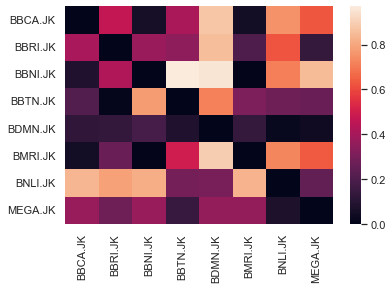

In [17]:
bank.coint_coef()

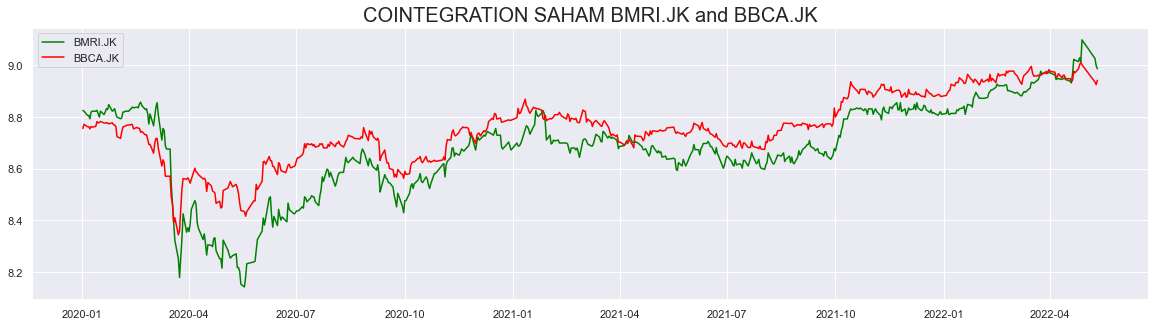

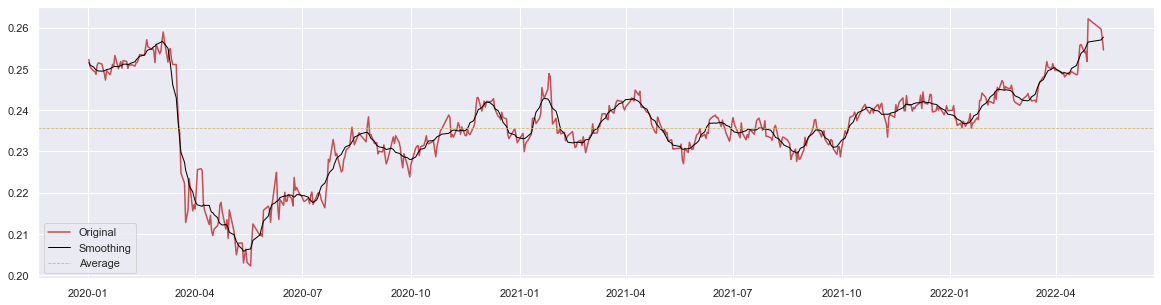

In [18]:
bank.plot_coint()
bank.plot_pt()

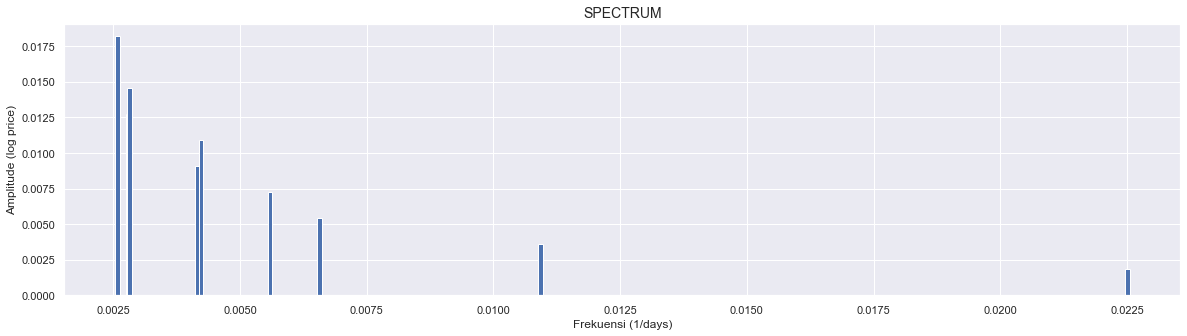

In [19]:
bank.plot_fft()

In [20]:
bank.hasil(10000000)

,Days,Rp,Rp/day
0,550.000000,450153.868210,818.461579
1,275.000000,218578.268458,794.830067
2,183.333333,131424.563815,716.861257
3,137.500000,111867.428823,813.581301
4,110.000000,83083.093228,755.300848
5,91.666667,84670.783622,923.681276
6,78.571429,55815.190633,710.375154
7,68.750000,56539.363081,822.390736
8,61.111111,51927.602537,849.724405
9,55.000000,51724.850885,940.451834
